# Plotting II

In [1]:
from utils import (
                BaseForecaster, 
                ResidualForecaster,
                TimeSeriesPreprocessor,
                crps,
                HistoricalForecaster
)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
from darts import TimeSeries
import numpy as np
import CRPS.CRPS as forecastscore
from darts.metrics import rmse
import matplotlib as mpl

targets = pd.read_csv("targets.csv.gz")

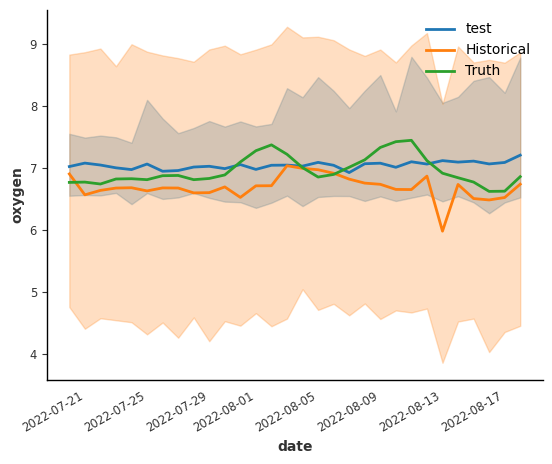

In [5]:
plot_forecasts(['test'], '2022_07_20', targets, 'FLNT', 'oxygen')

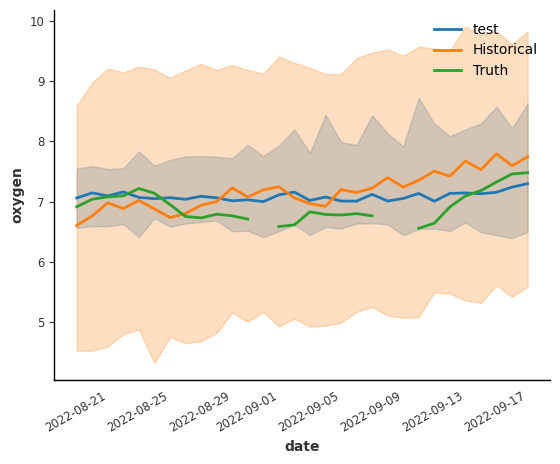

In [6]:
plot_forecasts(['test'], '2022_08_19', targets, 'FLNT', 'oxygen')

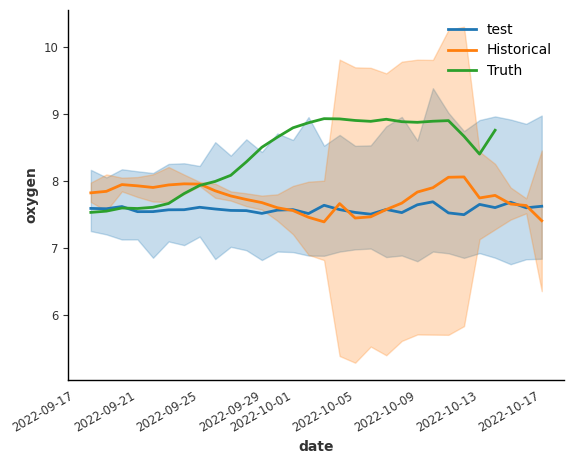

In [7]:
plot_forecasts(['test'], '2022_09_18', targets, 'FLNT', 'oxygen')

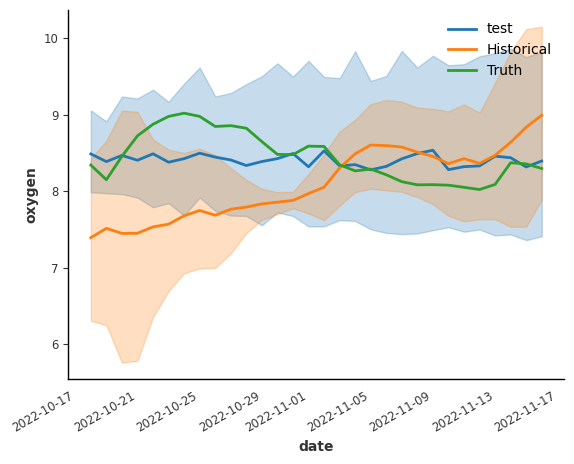

In [8]:
plot_forecasts(['test'], '2022_10_18', targets, 'FLNT', 'oxygen')

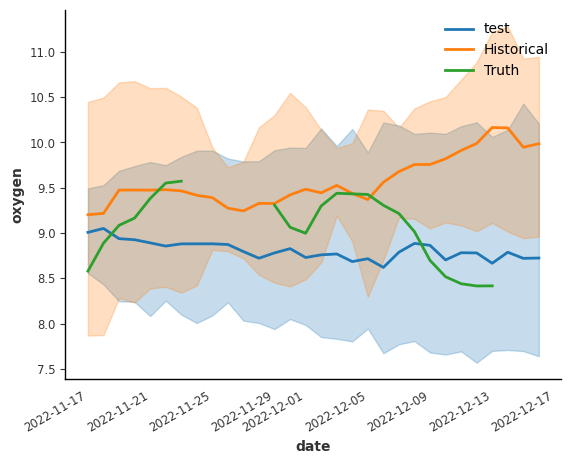

In [9]:
plot_forecasts(['test'], '2022_11_17', targets, 'FLNT', 'oxygen')

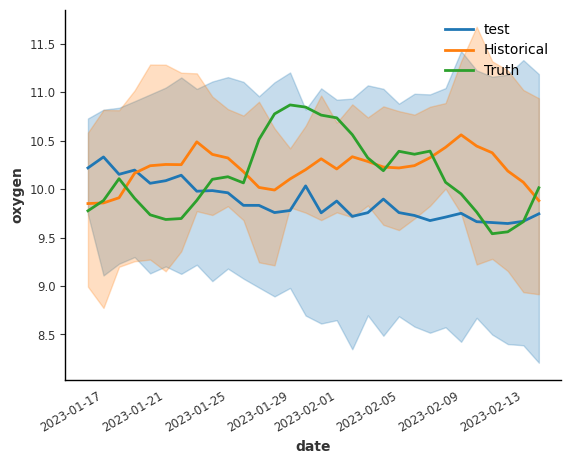

In [12]:
plot_forecasts(['test'], '2023_01_16', targets, 'FLNT', 'oxygen')

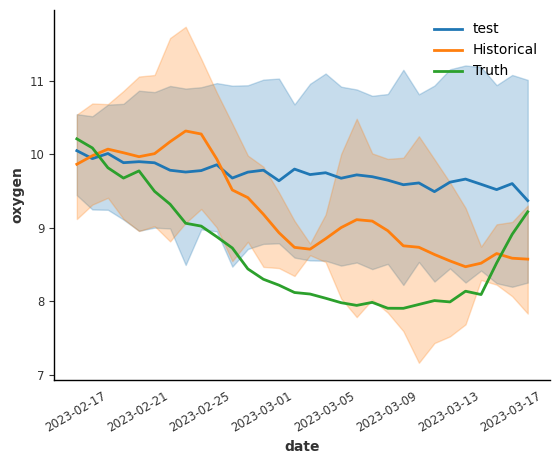

In [13]:
plot_forecasts(['test'], '2023_02_15', targets, 'FLNT', 'oxygen')

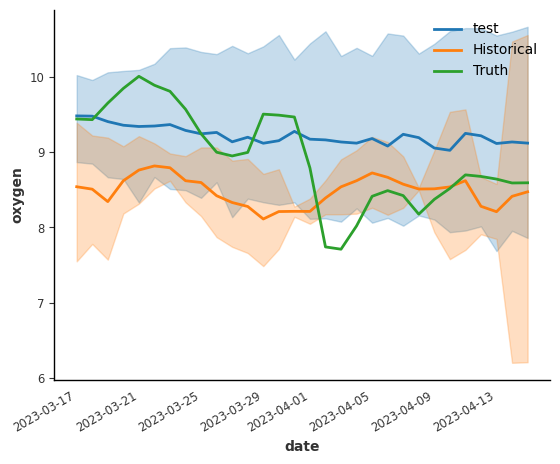

In [14]:
plot_forecasts(['test'], '2023_03_17', targets, 'FLNT', 'oxygen')

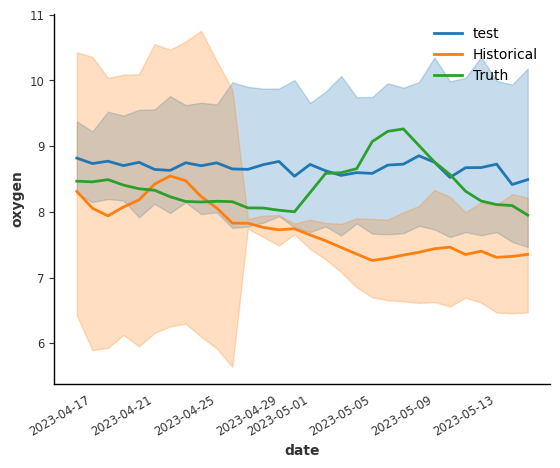

In [15]:
plot_forecasts(['test'], '2023_04_16', targets, 'FLNT', 'oxygen')

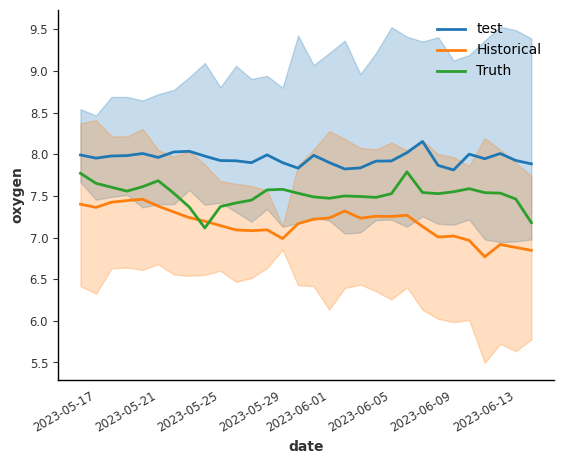

In [16]:
plot_forecasts(['test'], '2023_05_16', targets, 'FLNT', 'oxygen')

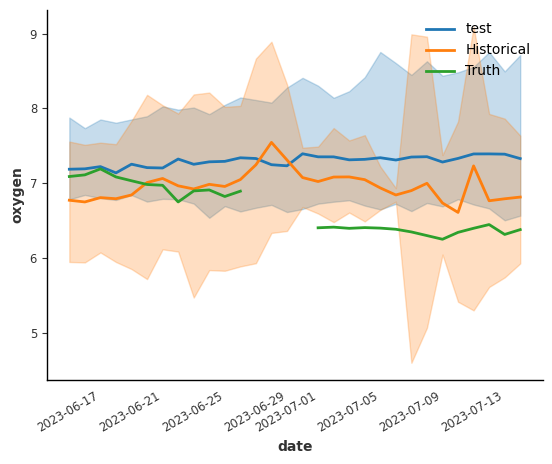

In [18]:
plot_forecasts(['test'], '2023_06_15', targets, 'FLNT', 'oxygen')

In [2]:
def plot_forecasts(prefix_list, date, targets_df, site_id, target_variable, plot_name=None):
    cmap = mpl.colormaps["tab10"]
    colors = cmap.colors
    # Loading the forecast csv and creating a time series
    for i, prefix in enumerate(prefix_list):
        csv_name = f"{prefix}_{date}.csv"
        df = pd.read_csv(csv_name)
        times = pd.to_datetime(df["datetime"])
        times = pd.DatetimeIndex(times)
        values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((len(times), 1, -1))
        model_forecast = TimeSeries.from_times_and_values(times, 
                                                          values, 
                                                          fill_missing_dates=True, freq="D")
        model_forecast.plot(label=f"{prefix}", color=colors[i])

    # Getting the validation series directly from the targets csv
    date = model_forecast.time_index[0]
    forecast_horizon = len(model_forecast)
    validation_series = get_validation_series(
        targets_df, 
        site_id, 
        target_variable, 
        date, 
        forecast_horizon
    )

    # Now, making the forecast based off of historical mean and std
    historical_model = HistoricalForecaster(
        targets=targets_df,
        site_id=site_id,
        target_variable=target_variable,
        output_csv_name="historical_forecaster_output.csv",
        validation_split_date=str(model_forecast.time_index[0])[:10],
        forecast_horizon=len(model_forecast),
    )
    historical_model.make_forecasts()
    i += 1
    historical_model.forecast_ts.plot(label="Historical", color=colors[i])
    validation_series.plot(label="Truth", color=colors[i+1])
    x = plt.xlabel("date")
    y = plt.ylabel(target_variable)
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.grid(False)

    # Saving the plot if desired
    if plot_name != None:
        if not os.path.exists(f"plots/{site_id}/{target_variable}/"):
            os.makedirs(f"plots/{site_id}/{target_variable}/")
        plt.savefig(f"plots/{site_id}/{target_variable}/{plot_name}")

In [19]:
def get_validation_series(targets_df, site_id, target_variable, date, forecast_horizon):
    # Being careful here with the date, note that I am matching the forecast,
    # so I don't need to advance.
    date_range = pd.date_range(date, 
                               periods=forecast_horizon, 
                               freq='D')
    # Filter targets df for site and variable
    site_df = targets_df[targets_df["site_id"] == site_id]
    site_var_df_ = site_df[["datetime", target_variable]]
    site_var_df = site_var_df_.copy()
    site_var_df["datetime"] = pd.to_datetime(site_var_df_["datetime"])
    validation_df = pd.DataFrame()
    # Now creating a new dataframe of observed series from the forecast
    # window
    for date in date_range:
        entry = site_var_df[site_var_df.datetime == date]
        validation_df = pd.concat(
            [validation_df, entry], 
            axis=0
        ).reset_index(drop=True)
        
    times = pd.to_datetime(validation_df.datetime)
    times = pd.DatetimeIndex(times)
    validation_series = TimeSeries.from_times_and_values(
        times,
        validation_df[[target_variable]],
        fill_missing_dates=True,
        freq="D",
    )
    
    return validation_series

def filter_forecast_df(forecast_df, validation_series):
    """
    Assumes validation series is a TimeSeries
    and forecast_df has an datetime index
    """
    gaps = validation_series.gaps()
    # Filtering forecast df to only include dates in the validation series
    if len(gaps) > 0:
        for i in range(len(gaps)):
            gap_start = gaps.iloc[i].gap_start
            gap_end = gaps.iloc[i].gap_end
            forecast_df = forecast_df[(forecast_df.index < gap_start) \
                                      | (forecast_df.index > gap_end)]

    times = forecast_df.index
    validation_series = validation_series.pd_series().dropna()
    # Checking that the dates indices are the same, i.e. that filtering worked properly
    assert (validation_series.index == forecast_df.index).all()

    values = forecast_df.loc[:, forecast_df.columns!="datetime"].to_numpy().reshape(
                                                                (len(times), 1, -1))
    filtered_forecast_ts = TimeSeries.from_times_and_values(
        times, 
        values, 
    )

    return filtered_forecast_ts, validation_series

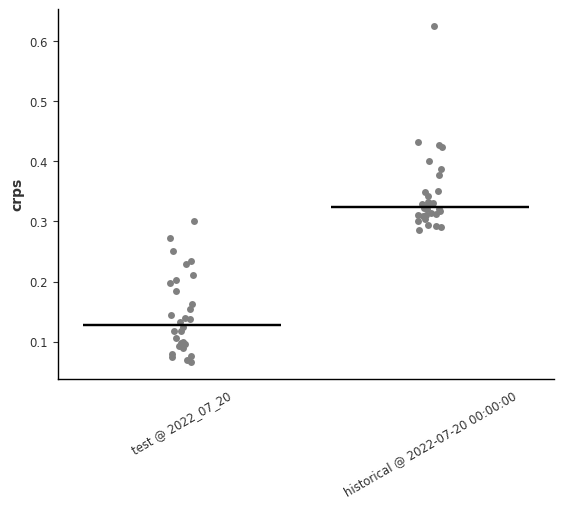

In [27]:
plot_crps_strip(['2022_07_20'], 'test', targets, 'FLNT', 'oxygen')

In [26]:
def plot_crps_strip(date_list, prefix, targets_df, site_id, target_variable, plot_name=None):
    cmap = mpl.colormaps["tab20"]
    colors = cmap.colors
    score_dict = {}
    # Loading the forecast csv and creating a time series
    for i, date_str in enumerate(date_list):
        csv_name = f"{prefix}_{date_str}.csv"
        forecast_df = pd.read_csv(csv_name)
        forecast_df["datetime"] = pd.to_datetime(forecast_df["datetime"])
        times = pd.DatetimeIndex(forecast_df["datetime"])
        forecast_df = forecast_df.set_index("datetime")

        # Getting the validation set from targets
        if i == 0:
            date = forecast_df.index[0]
            forecast_horizon = len(forecast_df)
            validation_series = get_validation_series(
                targets_df, 
                site_id, 
                target_variable, 
                date, 
                forecast_horizon,
            )
        # Filter the forecast to only include dates with observations
        filtered_model_forecast, filtered_validation_series = filter_forecast_df(
            forecast_df,
            validation_series
        )
        # Computing CRPS and plotting it as well as its mean (dashed)
        scores = crps(
            filtered_model_forecast, 
            filtered_validation_series
        )
        key_name = prefix + " @ " + date.strftime('%Y_%m_%d')
        score_dict[key_name] = scores.pd_dataframe().values[:, 0]
            
        # Now, making the forecast based off of historical mean and std
        historical_model = HistoricalForecaster(targets=targets_df,
                              site_id=site_id,
                              target_variable=target_variable,
                              output_csv_name="historical_forecaster_output.csv",
                              validation_split_date=str(forecast_df.index[0])[:10],
                              forecast_horizon=len(forecast_df),)
        # Computing CRPS of historical forecast and plotting
        historical_model.make_forecasts()
        historical_forecast_df = historical_model.forecast_ts.pd_dataframe(
            suppress_warnings=True
        )
        filtered_historical_forecast, filtered_validation_series = filter_forecast_df(
            historical_forecast_df,
            validation_series
        )
        scores = crps(filtered_historical_forecast, filtered_validation_series)
        score_dict[f"historical @ {date}"] = scores.pd_dataframe().values[:, 0]

    # Now creating the plot
    p = sns.stripplot(score_dict, jitter=0.05, color='0.5')

    # plot the mean line
    sns.boxplot(
        showmeans=False,
        meanline=False,
        meanprops={'color': 'k', 'ls': '-', 'lw': 2},
        medianprops={'visible': True, 'lw':1.75},
        whiskerprops={'visible': False},
        zorder=10,
        data=score_dict,
        showfliers=False,
        showbox=False,
        showcaps=False,
        ax=p
    )
    plt.grid(False)
    plt.ylabel("crps")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    
    # Saving the plot if desired
    if plot_name != None:
        if not os.path.exists(f"plots/{site_id}/{target_variable}/"):
            os.makedirs(f"plots/{site_id}/{target_variable}/")
        plt.savefig(f"plots/{site_id}/{target_variable}/{plot_name}")

In [ ]:
plot_crps_bydate('test_20*', targets, 'FLNT', 'oxygen')

> /tmp/ipykernel_4983/3554156828.py(10)plot_crps_bydate()
      8     import pdb; pdb.set_trace()
      9 
---> 10     for site_id in targets_df.site_id.unique():
     11         score_dict = modify_score_dict(model, targets_df, target_variable, site_id, suffix, score_dict)
     12 



ipdb>  csv_list


['test_2023_04_16.csv', 'test_2022_10_18.csv', 'test_2022_11_17.csv', 'test_2023_03_17.csv', 'test_2022_12_17.csv', 'test_2022_09_18.csv', 'test_2023_02_15.csv', 'test_2022_08_19.csv', 'test_2023_01_16.csv', 'test_2023_05_16.csv', 'test_2023_06_15.csv', 'test_2022_07_20.csv']


In [28]:
import glob
def plot_crps_bydate(prefix, targets_df, site_id, target_variable, suffix="", plot_name=None):

    plt.figure(figsize=(16, 12))
    score_dict = {}

    csv_list = glob.glob(prefix)
    import pdb; pdb.set_trace()
    
    for csv in csv_list:
        score_dict = modify_score_dict(model, targets_df, target_variable, site_id, suffix, score_dict)

    score_df = pd.DataFrame([(site_id, data_dict['crps_forecast'][i], data_dict['crps_historical'][i]) \
                                 for site_id, data_dict in score_dict.items() \
                                 for i in range(len(data_dict['crps_forecast']))],
                            columns=["site_id", f'{model}', 'historical'])
    score_df = pd.melt(score_df, id_vars=["site_id"], var_name="model_type", value_name="crps")

    # Now creating the plot
    p = sns.stripplot(score_df, x="site_id", y="crps", hue="model_type", dodge=True, palette="tab20")

    # plot the mean line
    sns.boxplot(showmeans=False,
                meanline=False,
                meanprops={'color': 'k', 'ls': '-', 'lw': 2},
                medianprops={'visible': True, 'lw':1.75},
                whiskerprops={'visible': False},
                zorder=10,
                data=score_dict,
                showfliers=False,
                showbox=False,
                showcaps=False,
                ax=p)
    plt.grid(False)
    plt.ylabel("crps")
    ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    plt.xticks(rotation=30)
    plt.title(f'{target_variable}')
    
    # Saving the plot if desired
    if plot_name != None:
        if not os.path.exists(f"plots/{site_id}/{target_variable}/"):
            os.makedirs(f"plots/{site_id}/{target_variable}/")
        plt.savefig(f"plots/{site_id}/{target_variable}/{plot_name}")

In [ ]:
def modify_score_dict(csv, model, targets_df, target_variable, site_id, suffix, score_dict, score_rmse=False):
    try:
        forecast_df = pd.read_csv(csv)
    except:
        return score_dict
    forecast_df["datetime"] = pd.to_datetime(forecast_df["datetime"])
    times = pd.DatetimeIndex(forecast_df["datetime"])
    forecast_df = forecast_df.set_index("datetime")

    # Getting the validation set from targets
    forecast_horizon = len(forecast_df)
    validation_series = get_validation_series(
        targets_df, 
        site_id, 
        target_variable, 
        times[0], 
        forecast_horizon,
    )

    # If there is no validation set at the site skip
    if len(validation_series) == 0:
        return score_dict

    try:
        filtered_model_forecast, filtered_validation_series = filter_forecast_df(
            forecast_df, 
            validation_series
        )
    except:
        return score_dict

    # Initialize in case site id is empty at the site
    time_str = times[0].strftime('%Y_%m_%d')
    if time_str not in score_dict:
        score_dict[time_str] = {}
        
    # Computing CRPS and recording
    if score_rmse:
        filtered_validation_ts = TimeSeries.from_times_and_values(
            filtered_validation_series.index, 
            filtered_validation_series.values, 
            fill_missing_dates=False
        )
        rmse_score = rmse(filtered_validation_ts, filtered_model_forecast)
        score_dict[time_str]["rmse_forecast"] = rmse_score
    else:
        crps_scores = crps(filtered_model_forecast, filtered_validation_series)
        score_dict[time_str]["crps_forecast"] = crps_scores.pd_dataframe().values[:, 0]
        
    # Now, making the forecast based off of historical mean and std
    historical_model = HistoricalForecaster(
        targets=targets_df,
        site_id=site_id,
        target_variable=target_variable,
        output_csv_name=None,
        validation_split_date=str(times[0])[:10],
        forecast_horizon=forecast_horizon,
    )
    # Computing CRPS of historical forecast and plotting
    historical_model.make_forecasts()
    historical_forecast_df = historical_model.forecast_ts.pd_dataframe(
        suppress_warnings=True
    )
    filtered_historical_forecast, filtered_validation_series = filter_forecast_df(
        historical_forecast_df, 
        validation_series
    )
    if score_rmse:
        rmse_score = rmse(filtered_validation_ts, filtered_historical_forecast)
        score_dict[time_str]["rmse_historical"] = rmse_score
    else:
        crps_scores = crps(filtered_historical_forecast, filtered_validation_series)
        score_dict[time_str]["crps_historical"] = crps_scores.pd_dataframe().values[:, 0]
    return score_dict